In [1]:
from utils import *

VISUALIZE_EMBEDDINGS = True

## Prepare Data

In [2]:
all_data = prepare_full_MNIST_databunch()
toytest = ToyAnomalyDetection(all_data, n_anomaly_labels=5, n_cases=10, distance='euclidean')

## 1. Conventional softmax model

epoch,train_loss,valid_loss,accuracy,time
0,0.561386,0.412727,0.866000,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.129702,0.042874,0.988000,00:16
1,0.046028,0.043134,0.989200,00:16
2,0.035801,0.016364,0.994800,00:16


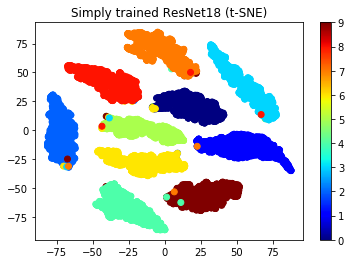

In [3]:
# Define model learner
def learner_conventional(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(3)
    return learn

def visualize_embeddings(learn, title):
    embs = get_embeddings(body_feature_model(learn.model), all_data.valid_dl)
    show_2D_tSNE(embs, [int(y) for y in all_data.valid_ds.y], title=title)

if VISUALIZE_EMBEDDINGS:
    learn = learner_conventional(all_data)
    visualize_embeddings(learn, 'Simply trained ResNet18 (t-SNE)')    

In [4]:
# Test model
toytest.do_tests('Conventional', learner_conventional)

Testing Conventional for case #0


epoch,train_loss,valid_loss,accuracy,time
0,0.509094,0.440575,0.844065,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.101733,0.034869,0.988274,00:08
1,0.042019,0.013863,0.996709,00:08
2,0.014671,0.011158,0.996709,00:08


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing Conventional for case #1


epoch,train_loss,valid_loss,accuracy,time
0,0.463725,0.366276,0.869873,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.103957,0.033396,0.989291,00:08
1,0.027770,0.015233,0.995959,00:08
2,0.020509,0.008454,0.996767,00:08


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing Conventional for case #2


epoch,train_loss,valid_loss,accuracy,time
0,0.361343,0.320170,0.886656,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.081936,0.037131,0.988490,00:08
1,0.040120,0.015369,0.996293,00:08
2,0.018317,0.008221,0.997854,00:08


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing Conventional for case #3


epoch,train_loss,valid_loss,accuracy,time
0,0.400156,0.318420,0.895906,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.080215,0.058685,0.981871,00:08
1,0.034888,0.009467,0.997271,00:08
2,0.016349,0.006739,0.997466,00:08


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing Conventional for case #4


epoch,train_loss,valid_loss,accuracy,time
0,0.354183,0.287294,0.902439,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.068441,0.026152,0.992838,00:08
1,0.022074,0.013910,0.995741,00:08
2,0.012801,0.005264,0.998258,00:08


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing Conventional for case #5


epoch,train_loss,valid_loss,accuracy,time
0,0.280206,0.218291,0.927612,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.065230,0.010307,0.997665,00:08
1,0.023312,0.009670,0.996692,00:08
2,0.010744,0.002234,0.999416,00:08


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing Conventional for case #6


epoch,train_loss,valid_loss,accuracy,time
0,0.415543,0.306558,0.890913,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.064030,0.016060,0.995248,00:08
1,0.033580,0.011614,0.997228,00:08
2,0.012415,0.005765,0.998020,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing Conventional for case #7


epoch,train_loss,valid_loss,accuracy,time
0,0.519536,0.406264,0.856996,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.073825,0.019803,0.994460,00:08
1,0.030959,0.012146,0.996922,00:08
2,0.011852,0.007159,0.998153,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing Conventional for case #8


epoch,train_loss,valid_loss,accuracy,time
0,0.424514,0.342512,0.882341,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.079336,0.022554,0.993019,00:08
1,0.036531,0.014512,0.995277,00:08
2,0.017480,0.006227,0.998152,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing Conventional for case #9


epoch,train_loss,valid_loss,accuracy,time
0,0.442109,0.349107,0.880017,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.079397,0.039385,0.986347,00:08
1,0.029875,0.019963,0.994828,00:08
2,0.015588,0.006721,0.998138,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


In [5]:
distance_df, (auc, fpr, tpr), worst_test_info = toytest.results['Conventional'][0]
worst_test_info

,x,y,distance,train_idx,train_x,train_y
800,2/img2_001546.png,2,0.234307,14056,8/img8_013680.png,8
2110,4/img4_004519.png,4,0.344690,3111,9/img9_020445.png,9
2224,4/img4_003172.png,4,0.358347,4202,9/img9_036024.png,9
2284,4/img4_000139.png,4,0.387698,4007,9/img9_046701.png,9
2204,4/img4_004860.png,4,0.395675,5581,9/img9_031299.png,9


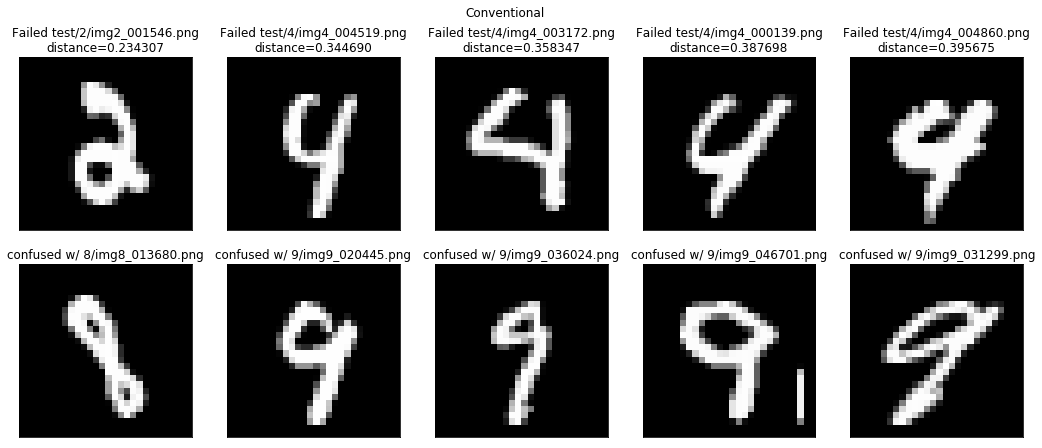

In [6]:
toytest.show_worst_test_images('Conventional', worst_test_info, 0)

## 2. L2-constrained Softmax Loss

- R. Ranjan, C. D. Castillo, and R. Chellappa. L2-constrained softmax loss for discriminative face verification. arXiv preprint arXiv:1703.09507, 2017. https://arxiv.org/pdf/1703.09507.pdf

epoch,train_loss,valid_loss,accuracy,time
0,1.068220,1.003692,0.880800,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.817395,0.762780,0.987100,00:16
1,0.806318,0.761746,0.987000,00:17
2,0.787669,0.749139,0.993400,00:17
3,0.780962,0.747024,0.994700,00:16
4,0.773764,0.746176,0.995300,00:17


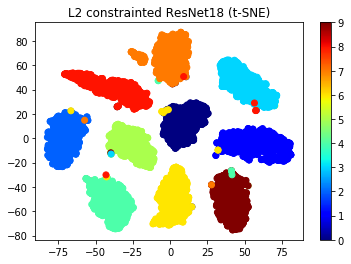

In [7]:
# Define model learner
class L2ConstraintedNet(nn.Module):
    def __init__(self, org_model, alpha=16, num_classes=1000):
        super().__init__()
        self.org_model = org_model
        self.alpha = alpha

    def forward(self, x):
        x = self.org_model(x)
        
        l2 = torch.sqrt((x**2).sum())
        x = self.alpha * (x / l2)
        return x

def learner_L2ConstraintedNet(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = L2ConstraintedNet(learn.model)
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_embeddings(learner_L2ConstraintedNet(all_data), 'L2 constrainted ResNet18 (t-SNE)')

In [8]:
toytest.do_tests('L2-constrainted', learner_L2ConstraintedNet)

Testing L2-constrainted for case #0


epoch,train_loss,valid_loss,accuracy,time
0,0.710286,0.667354,0.847562,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.418500,0.372789,0.992388,00:09
1,0.399284,0.375467,0.989303,00:08
2,0.387889,0.364320,0.995474,00:08
3,0.376063,0.360443,0.997737,00:08
4,0.376065,0.361519,0.997326,00:09


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing L2-constrainted for case #1


epoch,train_loss,valid_loss,accuracy,time
0,0.670559,0.637028,0.864821,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.411591,0.399451,0.972520,00:09
1,0.404377,0.366176,0.994342,00:10
2,0.385963,0.365466,0.993736,00:09
3,0.378335,0.360976,0.996969,00:09
4,0.373596,0.358983,0.997575,00:09


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing L2-constrainted for case #2


epoch,train_loss,valid_loss,accuracy,time
0,0.627572,0.596645,0.886851,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.410422,0.373386,0.992977,00:08
1,0.396574,0.368555,0.994147,00:08
2,0.385383,0.363747,0.996098,00:08
3,0.378634,0.360084,0.997659,00:08
4,0.375758,0.359128,0.997659,00:08


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing L2-constrainted for case #3


epoch,train_loss,valid_loss,accuracy,time
0,0.634422,0.579003,0.902729,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.414501,0.372666,0.991813,00:08
1,0.393059,0.366528,0.994542,00:08
2,0.385122,0.368061,0.992788,00:08
3,0.377987,0.361689,0.996491,00:09
4,0.374176,0.358927,0.998051,00:09


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing L2-constrainted for case #4


epoch,train_loss,valid_loss,accuracy,time
0,0.619389,0.562139,0.915602,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.405668,0.370416,0.993806,00:08
1,0.389539,0.364176,0.995161,00:08
2,0.382798,0.359947,0.996903,00:08
3,0.376310,0.357327,0.999032,00:08
4,0.372945,0.357857,0.998258,00:08


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing L2-constrainted for case #5


epoch,train_loss,valid_loss,accuracy,time
0,0.575776,0.528433,0.932672,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.400451,0.366367,0.995719,00:08
1,0.392623,0.359224,0.998054,00:08
2,0.377922,0.358313,0.998249,00:09
3,0.374488,0.356455,0.999222,00:09
4,0.374458,0.356005,0.999805,00:09


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing L2-constrainted for case #6


epoch,train_loss,valid_loss,accuracy,time
0,0.635159,0.580606,0.904177,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.404769,0.369449,0.993863,00:08
1,0.390824,0.363448,0.996040,00:08
2,0.384700,0.362323,0.996832,00:08
3,0.376264,0.359036,0.998218,00:08
4,0.375698,0.359223,0.997624,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing L2-constrainted for case #7


epoch,train_loss,valid_loss,accuracy,time
0,0.712035,0.666038,0.854739,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.408262,0.375414,0.989536,00:08
1,0.393291,0.365765,0.993229,00:08
2,0.386714,0.364135,0.996307,00:08
3,0.377494,0.361247,0.996307,00:08
4,0.372837,0.359744,0.997538,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing L2-constrainted for case #8


epoch,train_loss,valid_loss,accuracy,time
0,0.664641,0.629097,0.876386,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.415097,0.384447,0.986858,00:08
1,0.394638,0.366891,0.994045,00:08
2,0.384734,0.362029,0.996715,00:08
3,0.377967,0.361313,0.996715,00:08
4,0.374961,0.359630,0.997536,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing L2-constrainted for case #9


epoch,train_loss,valid_loss,accuracy,time
0,0.660141,0.599445,0.897600,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.412285,0.380631,0.987381,00:08
1,0.394728,0.363184,0.996069,00:08
2,0.383498,0.363728,0.995449,00:08
3,0.376010,0.357361,0.998345,00:08
4,0.374236,0.358049,0.998552,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


## 3. ArcFace

- J. Deng, J. Guo, and S. Zafeiriou. Arcface: Additive angular margin loss for deep face recognition. arXiv preprint arXiv:1801.07698, 2018. https://arxiv.org/pdf/1801.07698.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

In [9]:
try:
    from metrics import *
except:
    ! wget https://raw.githubusercontent.com/ronghuaiyang/arcface-pytorch/master/models/metrics.py
    from metrics import *

epoch,train_loss,valid_loss,accuracy,time
0,4.860809,3.213019,0.787200,00:15


epoch,train_loss,valid_loss,accuracy,time
0,1.062143,0.459500,0.981400,00:17
1,0.915657,0.407310,0.985800,00:17
2,0.530892,0.271375,0.990100,00:17
3,0.302700,0.184990,0.992400,00:17
4,0.285813,0.164071,0.993900,00:17


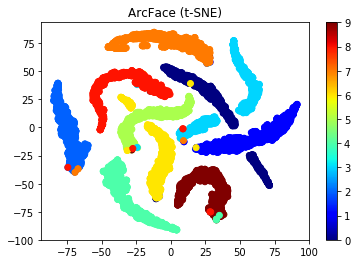

In [10]:
class LabelCatcher(LearnerCallback):
    last_labels = None

    def __init__(self, learn:Learner):
        super().__init__(learn)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        LabelCatcher.last_labels = last_target
        return {'last_input': last_input, 'last_target': last_target} 


class XFaceNet(nn.Module):
    def __init__(self, org_model, data, xface_product=ArcMarginProduct, m=0.5):
        super().__init__()
        self.org_model = org_model
        self.feature_model = body_feature_model(org_model)
        self.metric_fc = xface_product(512, data.c, m=m).cuda()
    
    def forward(self, x):
        x = self.feature_model(x)
        x = self.metric_fc(x, LabelCatcher.last_labels)
        return x


def learner_ArcFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, ArcMarginProduct, m=0.5)
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_embeddings(learner_ArcFace(all_data), 'ArcFace (t-SNE)')

In [11]:
toytest.do_tests('ArcFace', learner_ArcFace)

Testing ArcFace for case #0


epoch,train_loss,valid_loss,accuracy,time
0,4.875751,3.997014,0.757663,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.881642,0.611486,0.974902,00:08
1,0.746773,0.529769,0.983748,00:08
2,0.393592,0.273751,0.991771,00:08
3,0.230070,0.082309,0.997120,00:08
4,0.163818,0.073596,0.996914,00:08


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing ArcFace for case #1


epoch,train_loss,valid_loss,accuracy,time
0,4.282003,3.484705,0.795514,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.824072,0.609483,0.976763,00:08
1,0.585321,0.234710,0.991513,00:08
2,0.430937,0.354495,0.988685,00:08
3,0.170368,0.120378,0.995757,00:08
4,0.168730,0.110284,0.996161,00:08


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing ArcFace for case #2


epoch,train_loss,valid_loss,accuracy,time
0,3.677913,3.039375,0.817792,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.808936,0.599809,0.977565,00:09
1,0.546026,0.174912,0.993367,00:09
2,0.273220,0.186518,0.994343,00:09
3,0.231932,0.086691,0.997074,00:09
4,0.196256,0.072728,0.997659,00:09


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing ArcFace for case #3


epoch,train_loss,valid_loss,accuracy,time
0,3.704208,2.664556,0.823197,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.793968,0.241852,0.988109,00:09
1,0.615182,0.135702,0.994737,00:08
2,0.358263,0.123481,0.994932,00:08
3,0.173294,0.098466,0.996686,00:09
4,0.129079,0.064326,0.997661,00:08


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing ArcFace for case #4


epoch,train_loss,valid_loss,accuracy,time
0,3.338448,2.296947,0.850755,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.700824,0.184021,0.990515,00:09
1,0.436553,0.109044,0.995741,00:09
2,0.300031,0.073237,0.997871,00:09
3,0.176964,0.069712,0.996322,00:09
4,0.090805,0.037530,0.997677,00:09


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing ArcFace for case #5


epoch,train_loss,valid_loss,accuracy,time
0,2.657687,1.864736,0.875073,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.658154,0.293778,0.985990,00:09
1,0.533369,0.132328,0.994941,00:08
2,0.246994,0.091103,0.996303,00:09
3,0.116571,0.031067,0.998832,00:09
4,0.080670,0.048049,0.998443,00:08


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing ArcFace for case #6


epoch,train_loss,valid_loss,accuracy,time
0,3.674413,2.440916,0.837062,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.641728,0.161911,0.992873,00:08
1,0.517988,0.219067,0.992675,00:08
2,0.392904,0.152396,0.995050,00:08
3,0.142768,0.123536,0.996040,00:08
4,0.157651,0.120157,0.996040,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing ArcFace for case #7


epoch,train_loss,valid_loss,accuracy,time
0,4.811576,3.437826,0.777595,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.681821,0.286009,0.987074,00:08
1,0.575880,0.295072,0.990767,00:08
2,0.377118,0.101523,0.996307,00:08
3,0.216382,0.117949,0.996102,00:08
4,0.121208,0.092387,0.996922,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing ArcFace for case #8


epoch,train_loss,valid_loss,accuracy,time
0,4.230720,3.089879,0.816016,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.803794,0.547559,0.978234,00:08
1,0.470812,0.305765,0.990554,00:08
2,0.342651,0.128746,0.996304,00:08
3,0.180020,0.157885,0.995072,00:08
4,0.094389,0.115796,0.996304,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing ArcFace for case #9


epoch,train_loss,valid_loss,accuracy,time
0,3.947207,2.739065,0.827265,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.854491,0.440744,0.980761,00:08
1,0.627594,0.330390,0.988829,00:08
2,0.411378,0.200336,0.993380,00:08
3,0.184039,0.065304,0.995242,00:08
4,0.149911,0.040419,0.998345,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


## 4. CosFace
- H. Wang, Y. Wang, Z. Zhou, X. Ji, D. Gong, J. Zhou, Z. Li, and W. Liu, CosFace: Large Margin Cosine Loss for Deep Face Recognition, arXiv preprint arXiv:1801.09414, 2018. https://arxiv.org/pdf/1801.09414.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

epoch,train_loss,valid_loss,accuracy,time
0,4.173792,2.928971,0.765200,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.921600,0.745434,0.964700,00:16
1,0.642424,0.456384,0.980500,00:16
2,0.489409,0.235744,0.989800,00:16
3,0.270213,0.167479,0.993000,00:16
4,0.161769,0.135498,0.994100,00:16


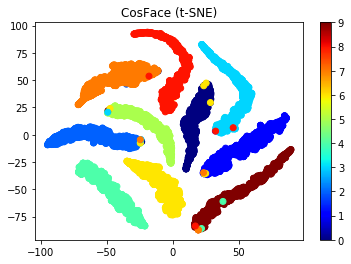

In [12]:
def learner_CosFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, AddMarginProduct, m=0.4)
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_embeddings(learner_CosFace(all_data), 'CosFace (t-SNE)')

In [13]:
toytest.do_tests('CosFace', learner_CosFace)

Testing CosFace for case #0


epoch,train_loss,valid_loss,accuracy,time
0,4.095674,3.350993,0.765480,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.782419,0.362075,0.977782,00:08
1,0.483197,0.213447,0.990537,00:08
2,0.320645,0.175493,0.993006,00:08
3,0.184471,0.077140,0.994651,00:08
4,0.167547,0.103828,0.995474,00:09


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing CosFace for case #1


epoch,train_loss,valid_loss,accuracy,time
0,3.588017,2.961049,0.787028,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.719036,0.415930,0.978379,00:09
1,0.507110,0.344912,0.985452,00:17
2,0.300742,0.096006,0.994544,00:10
3,0.184582,0.085269,0.996161,00:16
4,0.140313,0.078791,0.996161,00:10


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing CosFace for case #2


epoch,train_loss,valid_loss,accuracy,time
0,3.027972,2.671901,0.804136,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.732015,0.289035,0.982833,00:09
1,0.478787,0.275217,0.988685,00:09
2,0.317774,0.199518,0.990441,00:09
3,0.180007,0.086706,0.995513,00:09
4,0.117043,0.071336,0.996684,00:09


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing CosFace for case #3


epoch,train_loss,valid_loss,accuracy,time
0,3.127794,2.337598,0.820468,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.691788,0.378834,0.979922,00:08
1,0.489584,0.430864,0.981092,00:08
2,0.283051,0.109454,0.995127,00:08
3,0.189590,0.063420,0.996686,00:08
4,0.100958,0.048967,0.997076,00:08


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing CosFace for case #4


epoch,train_loss,valid_loss,accuracy,time
0,2.620106,1.991867,0.839528,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.557947,0.253009,0.985869,00:08
1,0.397067,0.080220,0.995548,00:08
2,0.262022,0.197607,0.992451,00:09
3,0.118400,0.082572,0.996516,00:08
4,0.069745,0.044018,0.997096,00:08


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing CosFace for case #5


epoch,train_loss,valid_loss,accuracy,time
0,2.208857,1.635384,0.873127,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.537332,0.155434,0.991827,00:08
1,0.342111,0.166062,0.992800,00:08
2,0.164602,0.052228,0.997859,00:08
3,0.131095,0.033163,0.997470,00:08
4,0.044313,0.014535,0.998638,00:09


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing CosFace for case #6


epoch,train_loss,valid_loss,accuracy,time
0,3.045958,2.314700,0.822411,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.526992,0.256332,0.987725,00:08
1,0.438796,0.173418,0.990497,00:08
2,0.235368,0.105136,0.994852,00:08
3,0.132831,0.087034,0.996238,00:08
4,0.076903,0.086887,0.995842,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing CosFace for case #7


epoch,train_loss,valid_loss,accuracy,time
0,3.950852,3.226586,0.752975,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.601210,0.369643,0.982355,00:08
1,0.363524,0.235293,0.990973,00:08
2,0.269430,0.123728,0.995076,00:08
3,0.163928,0.072531,0.996922,00:08
4,0.065083,0.066173,0.996307,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing CosFace for case #8


epoch,train_loss,valid_loss,accuracy,time
0,3.455509,2.542813,0.813142,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.628478,0.205925,0.988706,00:08
1,0.367757,0.286111,0.988296,00:08
2,0.246767,0.192650,0.992197,00:08
3,0.126186,0.103360,0.994661,00:08
4,0.085314,0.060797,0.997331,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing CosFace for case #9


epoch,train_loss,valid_loss,accuracy,time
0,3.245581,2.449639,0.817336,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.748256,0.210349,0.988622,00:08
1,0.528179,0.109050,0.994208,00:08
2,0.303574,0.145156,0.993587,00:08
3,0.147584,0.069559,0.996690,00:08
4,0.094074,0.055122,0.997311,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


## 5. SphereFace

- W. Liu, Y. Wen, Z. Yu, M. Li, B. Raj, and L. Song. SphereFace: Deep Hypersphere Embedding for Face Recognition. In CVPR, 2017. https://arxiv.org/pdf/1704.08063.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

epoch,train_loss,valid_loss,accuracy,time
0,1.071929,0.698812,0.812300,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.325848,0.079994,0.982200,00:17
1,0.216289,0.059656,0.990200,00:17
2,0.118580,0.050233,0.991600,00:17
3,0.076749,0.030517,0.995400,00:17
4,0.061022,0.026048,0.995600,00:17


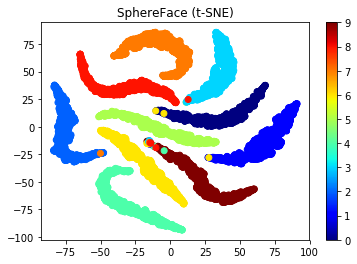

In [14]:
def learner_SphereFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, SphereProduct, m=int(4))
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_embeddings(learner_SphereFace(all_data), 'SphereFace (t-SNE)')

In [15]:
toytest.do_tests('ShpereFace', learner_SphereFace)

Testing ShpereFace for case #0


epoch,train_loss,valid_loss,accuracy,time
0,0.824386,0.660282,0.786258,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.190823,0.056351,0.986628,00:08
1,0.116742,0.022498,0.995474,00:08
2,0.070089,0.031521,0.993211,00:08
3,0.059925,0.014341,0.997737,00:08
4,0.028171,0.012503,0.997531,00:15


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing ShpereFace for case #1


epoch,train_loss,valid_loss,accuracy,time
0,0.816584,0.628059,0.808244,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.169932,0.092234,0.976359,00:08
1,0.117572,0.093006,0.981208,00:08
2,0.071247,0.024160,0.995959,00:09
3,0.043188,0.017194,0.996767,00:09
4,0.027727,0.011353,0.997979,00:08


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing ShpereFace for case #2


epoch,train_loss,valid_loss,accuracy,time
0,0.635780,0.482818,0.838471,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.154796,0.057658,0.988490,00:09
1,0.099743,0.063084,0.984003,00:09
2,0.066571,0.026096,0.995513,00:09
3,0.035799,0.011654,0.996489,00:09
4,0.022288,0.013045,0.997269,00:09


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing ShpereFace for case #3


epoch,train_loss,valid_loss,accuracy,time
0,0.697588,0.518954,0.842495,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.154035,0.061965,0.985770,00:09
1,0.100069,0.022665,0.994347,00:09
2,0.055642,0.020553,0.997076,00:09
3,0.043283,0.013669,0.997661,00:09
4,0.018693,0.009226,0.998441,00:09


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing ShpereFace for case #4


epoch,train_loss,valid_loss,accuracy,time
0,0.609177,0.418574,0.867596,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.124987,0.041208,0.989353,00:09
1,0.104762,0.046920,0.989160,00:09
2,0.053426,0.010343,0.996709,00:09
3,0.027815,0.005051,0.998258,00:09
4,0.016935,0.005704,0.998258,00:09


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing ShpereFace for case #5


epoch,train_loss,valid_loss,accuracy,time
0,0.503620,0.352827,0.895505,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.118289,0.037356,0.992800,00:09
1,0.095943,0.023177,0.996497,00:09
2,0.029289,0.004228,0.999222,00:09
3,0.022646,0.005792,0.999027,00:09
4,0.009641,0.004267,0.998832,00:09


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing ShpereFace for case #6


epoch,train_loss,valid_loss,accuracy,time
0,0.650653,0.477554,0.844783,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.138589,0.053932,0.987527,00:09
1,0.103216,0.022173,0.995842,00:09
2,0.051380,0.016732,0.995842,00:09
3,0.039074,0.011001,0.996832,00:09
4,0.012878,0.009824,0.997426,00:09


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing ShpereFace for case #7


epoch,train_loss,valid_loss,accuracy,time
0,0.820120,0.610590,0.792162,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.126253,0.041209,0.990973,00:08
1,0.092352,0.034354,0.993229,00:08
2,0.073591,0.022526,0.995486,00:08
3,0.042415,0.016563,0.997743,00:08
4,0.020608,0.014040,0.997333,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing ShpereFace for case #8


epoch,train_loss,valid_loss,accuracy,time
0,0.752206,0.547952,0.830185,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.165384,0.060164,0.987474,00:08
1,0.089609,0.024440,0.994867,00:08
2,0.059819,0.017495,0.996304,00:08
3,0.038267,0.015046,0.997741,00:08
4,0.018879,0.009339,0.998357,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing ShpereFace for case #9


epoch,train_loss,valid_loss,accuracy,time
0,0.738585,0.509220,0.846297,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.148623,0.042473,0.990898,00:08
1,0.096466,0.024881,0.993794,00:08
2,0.067305,0.018006,0.996276,00:08
3,0.034730,0.011190,0.997518,00:08
4,0.015604,0.010170,0.998138,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


## 6. Center Loss

- Y. Wen, K. Zhang, Z. Li, and Y. Qiao, A discriminative feature learning approach for deep face recognition,” in European Conference on Computer Vision. Springer, 2016, pp. 499–515. https://ydwen.github.io/papers/WenECCV16.pdf
- Pytorch implementation: https://github.com/KaiyangZhou/pytorch-center-loss

In [16]:
try:
    from center_loss import *
except:
    ! wget https://raw.githubusercontent.com/KaiyangZhou/pytorch-center-loss/master/center_loss.py
    from center_loss import *

epoch,train_loss,valid_loss,accuracy,time
0,2.207253,2.086369,0.783900,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.648287,1.544421,0.968900,00:16
1,1.619366,1.505929,0.986600,00:17
2,1.571209,1.489297,0.991800,00:20
3,1.545924,1.481111,0.994700,00:23
4,1.528375,1.480631,0.994500,00:17


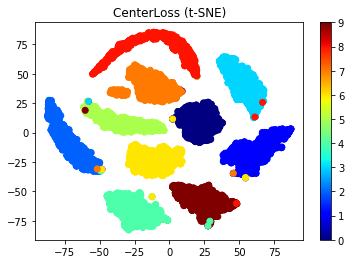

In [17]:
class WrapCenterLoss(nn.Module):
    "CenterLoss wrapper for https://github.com/KaiyangZhou/pytorch-center-loss."
    
    def __init__(self, learn, data, weight_cent=1/10):
        super().__init__()
        self.org_loss = learn.loss_func
        self.center_loss = CenterLoss(data.c, data.c)
        self.weight_cent = weight_cent

    def forward(self, output, target):
        dL = self.org_loss(output, target)
        dC = self.center_loss(output, target)
        #print(dL, dC)
        d = dL + self.weight_cent * dC
        return d

def learner_CenterLoss(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.loss_func = WrapCenterLoss(learn, train_data, weight_cent=1/8) ## Hand tuned
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_embeddings(learner_CenterLoss(all_data), 'CenterLoss (t-SNE)')

In [18]:
toytest.do_tests('CenterLoss', learner_CenterLoss)

Testing CenterLoss for case #0


epoch,train_loss,valid_loss,accuracy,time
0,1.537863,1.474262,0.742646,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.224411,1.172602,0.983748,00:08
1,1.194476,1.164157,0.988891,00:08
2,1.198150,1.155253,0.996709,00:08
3,1.173543,1.152193,0.998149,00:08
4,1.169038,1.151760,0.997943,00:08


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing CenterLoss for case #1


epoch,train_loss,valid_loss,accuracy,time
0,1.635409,1.577544,0.648010,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.252354,1.195685,0.968883,00:08
1,1.219798,1.184215,0.797333,00:08
2,1.215310,1.177713,0.798545,00:08
3,1.195202,1.165845,0.804405,00:08
4,1.192437,1.163912,0.804607,00:08


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing CenterLoss for case #2


epoch,train_loss,valid_loss,accuracy,time
0,1.589862,1.540422,0.797308,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.392721,1.363486,0.986734,00:08
1,1.366502,1.350958,0.990636,00:09
2,1.359119,1.341171,0.994928,00:08
3,1.361814,1.340486,0.997659,00:08
4,1.345782,1.339069,0.998439,00:08


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing CenterLoss for case #3


epoch,train_loss,valid_loss,accuracy,time
0,1.427427,1.346689,0.847758,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.962365,0.895082,0.990643,00:08
1,0.929258,0.875254,0.994347,00:08
2,0.926916,0.864211,0.997466,00:08
3,0.884770,0.860941,0.998635,00:08
4,0.887205,0.862575,0.998246,00:08


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing CenterLoss for case #4


epoch,train_loss,valid_loss,accuracy,time
0,1.389413,1.298136,0.833527,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.032276,0.982708,0.993806,00:08
1,1.024013,0.975614,0.996322,00:08
2,0.999727,0.968114,0.997677,00:09
3,0.994030,0.967207,0.998451,00:08
4,0.984258,0.968965,0.998258,00:08


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing CenterLoss for case #5


epoch,train_loss,valid_loss,accuracy,time
0,1.532978,1.468690,0.846663,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.280116,1.237216,0.995135,00:08
1,1.259788,1.234280,0.993578,00:08
2,1.243562,1.225701,0.997859,00:08
3,1.256223,1.223654,0.998443,00:08
4,1.239271,1.224433,0.998832,00:08


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing CenterLoss for case #6


epoch,train_loss,valid_loss,accuracy,time
0,1.540302,1.468748,0.749159,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.200055,1.150954,0.991685,00:08
1,1.198457,1.148173,0.995248,00:08
2,1.174146,1.142641,0.996832,00:08
3,1.174968,1.138279,0.998218,00:08
4,1.163880,1.138238,0.997624,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing CenterLoss for case #7


epoch,train_loss,valid_loss,accuracy,time
0,1.409394,1.318426,0.812680,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.936473,0.872205,0.995486,00:08
1,0.919253,0.862333,0.995691,00:08
2,0.901463,0.858949,0.996102,00:08
3,0.883046,0.860310,0.996922,00:08
4,0.877315,0.857987,0.998359,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing CenterLoss for case #8


epoch,train_loss,valid_loss,accuracy,time
0,1.704426,1.600666,0.708214,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.219052,1.160398,0.936345,00:08
1,1.206116,1.145239,0.989117,00:08
2,1.196883,1.134016,0.996099,00:08
3,1.178094,1.135258,0.996509,00:08
4,1.170351,1.134354,0.996920,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing CenterLoss for case #9


epoch,train_loss,valid_loss,accuracy,time
0,1.565813,1.493687,0.761688,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.256022,1.201244,0.994415,00:08
1,1.253523,1.207099,0.992553,00:08
2,1.235716,1.198996,0.995242,00:08
3,1.225663,1.192043,0.997724,00:08
4,1.216927,1.191175,0.997931,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


# Summary

# Stat: AUC


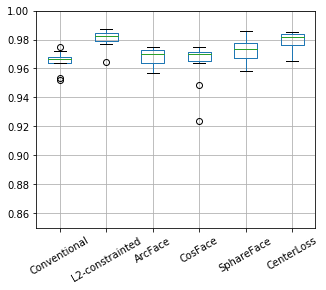

# Stat: Normalized distances


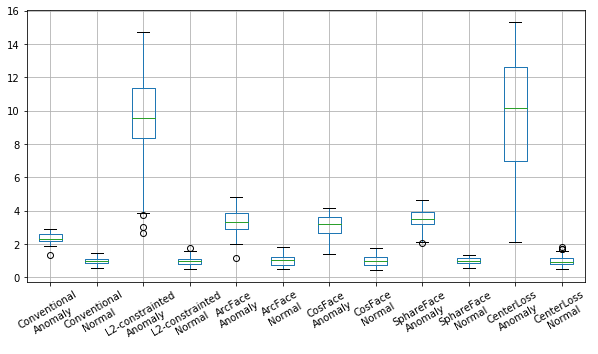


## [0, 1, 2, 3, 4]: normalized mean distance


,Conventional,L2-constrainted,ArcFace,CosFace,ShpereFace,CenterLoss
<unk> 0,2.745542,11.259808,3.338227,2.992735,3.205118,13.480673
<unk> 1,2.327105,9.482038,3.337244,3.320793,3.422165,13.545691
<unk> 2,2.249462,10.158229,3.826785,4.135788,3.433805,10.927568
<unk> 3,2.559015,8.395471,3.669745,3.463150,3.287673,7.606400
<unk> 4,1.943094,10.879955,3.233585,3.149849,3.068793,8.351856
5,1.457936,1.109024,1.276395,1.100993,0.929097,0.940586
6,1.114607,0.701924,0.588602,0.856541,1.040638,1.116930
7,0.970232,1.105195,0.731769,1.250282,0.854954,0.705811
8,1.251539,0.860288,1.241059,1.774741,1.171305,1.531447
9,0.959115,0.991673,1.325401,1.011892,0.827286,0.935601



## [1, 2, 3, 4, 5]: normalized mean distance


,Conventional,L2-constrainted,ArcFace,CosFace,ShpereFace,CenterLoss
0,1.041334,0.864534,1.195820,0.637712,0.970412,1.025489
<unk> 1,2.535385,14.731855,3.990134,3.234877,4.076097,13.015275
<unk> 2,2.104214,8.743683,3.603577,3.545379,3.666406,12.719289
<unk> 3,2.166524,14.248063,3.842346,3.330610,3.205294,8.082384
<unk> 4,2.243958,11.509762,3.184048,3.037668,3.711265,11.982302
<unk> 5,2.327951,12.144732,3.233610,3.094216,3.456995,11.212986
6,1.201702,0.777578,0.921188,0.613746,0.971364,0.792255
7,0.869263,0.921300,0.610129,0.892613,0.961382,1.200373
8,1.110523,1.486348,1.233877,1.133976,0.950902,1.707472
9,0.862152,1.749602,1.303132,0.755467,0.834027,1.104263



## [2, 3, 4, 5, 6]: normalized mean distance


,Conventional,L2-constrainted,ArcFace,CosFace,ShpereFace,CenterLoss
0,1.301426,0.704589,0.894934,0.776342,0.862222,0.539059
1,0.591418,1.040088,0.584827,0.636146,0.691162,0.760149
<unk> 2,2.651001,13.574076,4.438392,4.107324,3.931698,9.890239
<unk> 3,2.547595,9.366809,4.336394,4.184816,2.984208,9.515484
<unk> 4,2.363020,10.048896,3.635980,3.349971,3.882411,9.752823
<unk> 5,2.192186,7.204674,2.944075,3.692440,2.880831,6.785441
<unk> 6,2.385058,9.161004,3.627663,2.535602,2.908431,10.032047
7,1.391644,1.254003,1.121544,1.511876,1.364804,0.861205
8,0.980394,1.605672,1.142168,1.462403,0.888190,1.204698
9,0.857387,1.443855,1.084438,1.176349,1.160694,1.683579



## [3, 4, 5, 6, 7]: normalized mean distance


,Conventional,L2-constrainted,ArcFace,CosFace,ShpereFace,CenterLoss
0,0.849837,0.937575,1.153797,0.884233,0.964777,0.815909
1,0.736243,0.673966,1.057390,0.644643,0.725519,0.885201
2,0.941566,0.788149,0.792929,0.511261,0.940536,1.256924
<unk> 3,2.607921,9.895198,3.639834,3.917383,3.407842,13.846383
<unk> 4,2.181548,5.187458,2.076493,3.333594,3.609156,6.711049
<unk> 5,2.174359,8.527734,3.785177,2.954644,3.402542,10.107685
<unk> 6,2.527823,14.364649,3.925598,2.654794,3.503576,14.353493
<unk> 7,2.260588,9.217254,4.132238,3.786343,4.477325,14.917567
8,1.268146,1.545547,1.520641,1.245471,1.364367,1.536117
9,0.991365,1.099096,0.639901,1.075488,1.286517,1.206647



## [4, 5, 6, 7, 8]: normalized mean distance


,Conventional,L2-constrainted,ArcFace,CosFace,ShpereFace,CenterLoss
0,0.840383,0.591598,0.912986,0.780507,1.033813,1.562482
1,0.571005,0.557266,0.503182,0.645323,0.579297,0.613439
2,1.100810,1.170483,1.439437,1.114242,0.992096,0.938953
3,1.231070,0.924428,1.370871,1.320864,1.214901,1.000648
<unk> 4,1.919547,3.837685,2.614843,2.669195,2.047939,6.011309
<unk> 5,2.587128,7.119876,4.032161,3.615276,3.466637,9.203878
<unk> 6,1.889238,5.101081,1.978223,1.700445,3.261764,5.599729
<unk> 7,2.724066,12.533991,3.697341,3.647360,3.594438,10.752259
<unk> 8,2.818028,9.325804,4.847980,3.657263,4.303114,11.165884
9,0.819462,0.976811,1.020905,1.223177,1.060871,1.843596



## [5, 6, 7, 8, 9]: normalized mean distance


,Conventional,L2-constrainted,ArcFace,CosFace,ShpereFace,CenterLoss
0,0.951823,1.089387,1.052817,1.199943,0.929951,1.116646
1,0.723959,0.480745,0.485424,0.464027,0.722880,0.517477
2,1.190970,1.012117,1.798704,1.113465,1.354117,1.161035
3,1.436319,0.653800,0.757314,0.811394,0.838433,0.868079
4,0.901452,0.691613,1.132690,1.336530,1.116420,0.809470
<unk> 5,1.886341,3.025549,1.147489,1.390888,2.146345,2.153674
<unk> 6,2.108636,4.454616,2.346013,3.057895,3.123478,4.920835
<unk> 7,2.715087,10.127517,4.576694,4.042496,4.617079,10.758244
<unk> 8,2.300944,10.861803,2.362649,2.211890,3.184900,4.845491
<unk> 9,2.177114,9.888195,2.876676,2.749112,3.188936,9.760674



## [6, 7, 8, 9, 0]: normalized mean distance


,Conventional,L2-constrainted,ArcFace,CosFace,ShpereFace,CenterLoss
<unk> 0,2.692320,7.498213,3.531698,2.477466,3.933943,13.789912
1,0.577271,0.604434,0.581287,0.723232,0.609308,0.748428
2,1.102468,1.324148,1.152060,1.514769,1.070501,0.891866
3,1.112432,0.864207,0.518018,0.658989,1.112249,0.874298
4,1.344270,1.115856,1.505684,1.235012,1.064844,1.121069
5,0.867078,1.098460,1.070197,1.001607,0.882223,0.850205
<unk> 6,1.850663,6.991732,2.279262,2.779817,2.703276,3.973051
<unk> 7,2.494280,11.418386,3.897249,3.941418,3.958144,14.123838
<unk> 8,2.500203,9.134751,2.840136,3.095249,3.981713,10.659239
<unk> 9,2.876618,10.391400,4.112953,2.587357,4.001021,8.521881



## [7, 8, 9, 0, 1]: normalized mean distance


,Conventional,L2-constrainted,ArcFace,CosFace,ShpereFace,CenterLoss
<unk> 0,2.023844,9.988954,2.155552,2.648653,3.349655,6.081401
<unk> 1,2.292436,10.858153,2.247823,2.682707,4.021451,8.101994
2,0.860986,1.194400,1.080506,1.388895,1.274490,0.665859
3,1.132615,0.855603,0.685724,1.008361,0.859007,0.940942
4,0.846037,0.989474,0.692270,0.838906,0.869837,0.861620
5,1.131048,1.279401,0.808586,0.929418,1.015457,1.040232
6,0.752450,0.823935,0.662052,0.675553,1.173178,0.679768
<unk> 7,2.150248,8.328265,4.057025,3.457506,4.240799,11.032650
<unk> 8,2.731180,9.617176,3.819179,2.423859,3.544034,13.205864
<unk> 9,1.950123,9.414264,2.156583,2.516864,2.910072,6.680929



## [8, 9, 0, 1, 2]: normalized mean distance


,Conventional,L2-constrainted,ArcFace,CosFace,ShpereFace,CenterLoss
<unk> 0,1.318760,2.654624,2.869160,1.888709,2.655453,2.091076
<unk> 1,2.455330,8.128843,2.731899,2.670242,4.151782,15.299075
<unk> 2,2.649727,11.967156,3.066858,3.838435,3.550223,11.066682
3,1.062988,0.851900,1.260647,0.847578,0.992200,1.038431
4,1.007875,1.081513,0.750622,1.308170,0.945297,0.884628
5,1.104526,1.328084,1.200925,0.926151,1.254170,0.877280
6,0.765782,0.692897,0.592675,0.756983,1.071972,0.698450
7,0.863944,1.247065,1.115248,1.197492,0.852209,1.213456
<unk> 8,2.661531,8.707804,2.947579,3.165639,3.090216,10.241943
<unk> 9,2.399878,12.902796,3.323683,3.571829,3.914617,12.342718



## [9, 0, 1, 2, 3]: normalized mean distance


,Conventional,L2-constrainted,ArcFace,CosFace,ShpereFace,CenterLoss
<unk> 0,2.299376,3.761642,2.881817,1.895109,3.845698,4.291254
<unk> 1,2.630077,14.300702,4.136381,3.568721,4.322441,12.983753
<unk> 2,2.006354,9.165103,3.102866,3.206853,3.333857,12.127328
<unk> 3,2.134574,11.790294,3.206887,3.582856,3.474482,5.196075
4,1.105113,1.090126,1.292839,1.389651,0.971372,0.810958
5,0.995614,0.823379,1.021575,1.133396,1.159046,0.754664
6,1.181131,1.057828,0.918243,0.583133,1.209662,0.761897
7,0.743505,0.743187,0.960909,0.783725,0.807527,0.896771
8,0.927789,1.125847,1.235660,1.137333,1.202521,1.147642
<unk> 9,2.185638,13.110395,3.234947,3.738116,4.235679,14.563132


In [22]:
toytest.test_summary(auc_range=[0.85, 1.0], dist_range=None)
toytest.save_results('results_AnomalyMNIST')

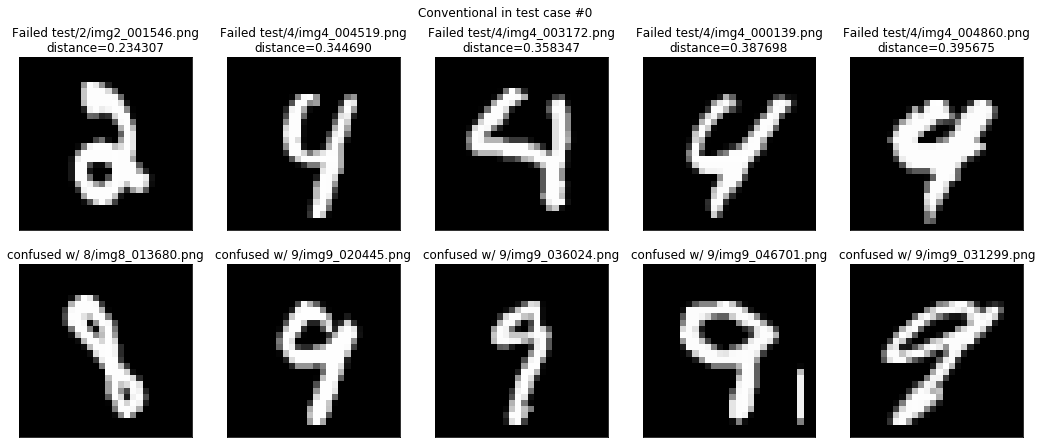

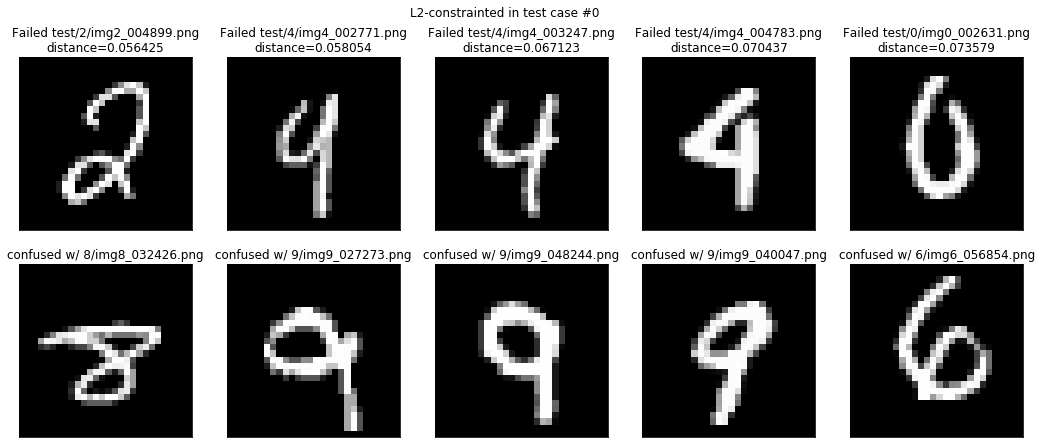

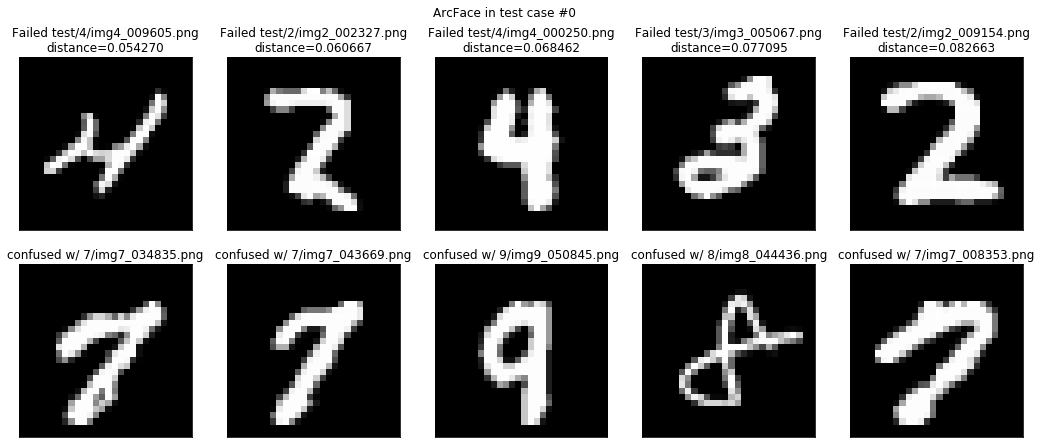

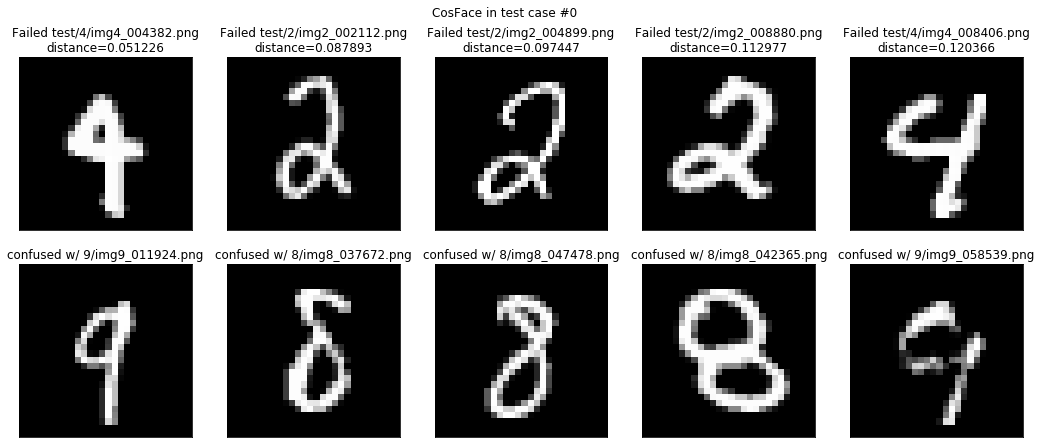

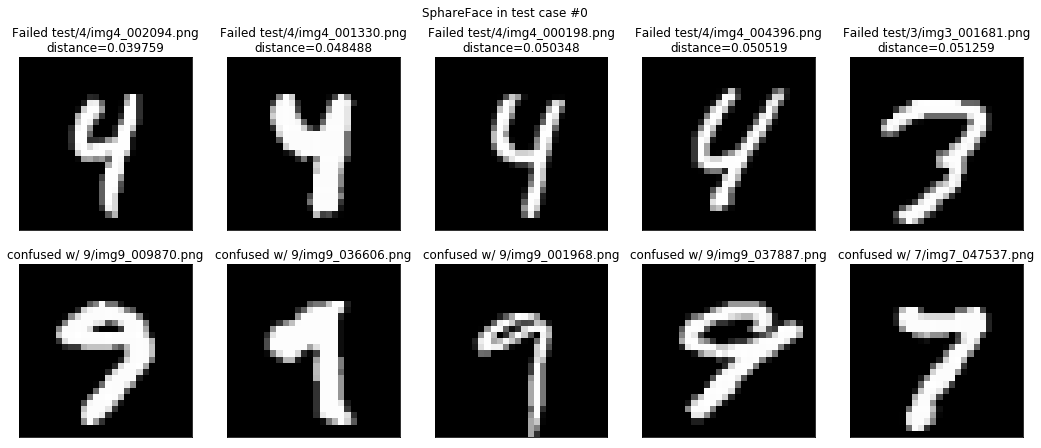

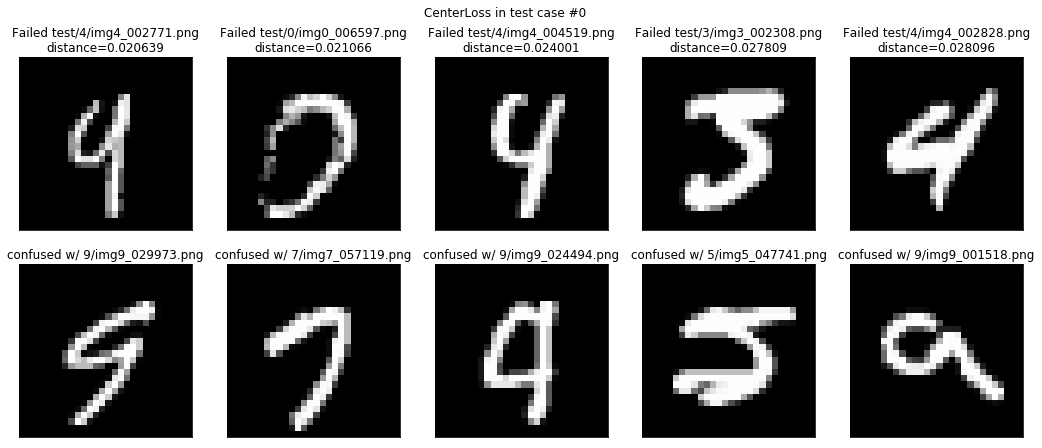

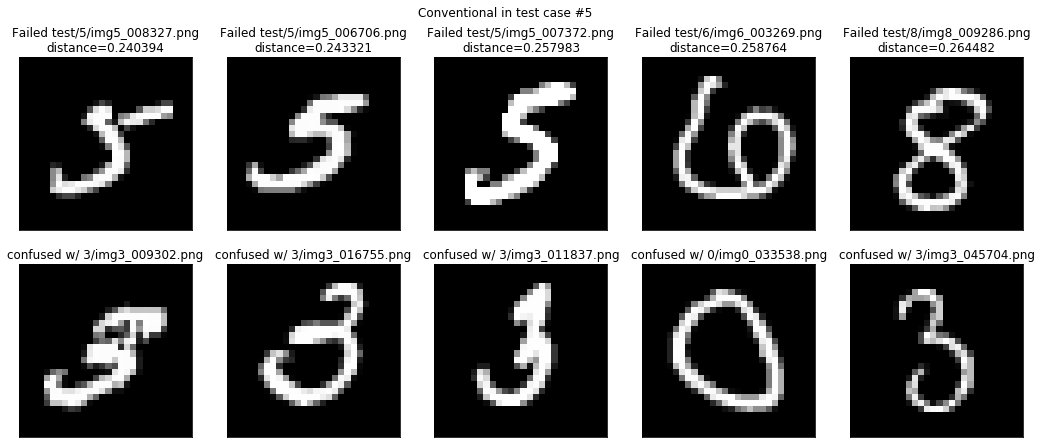

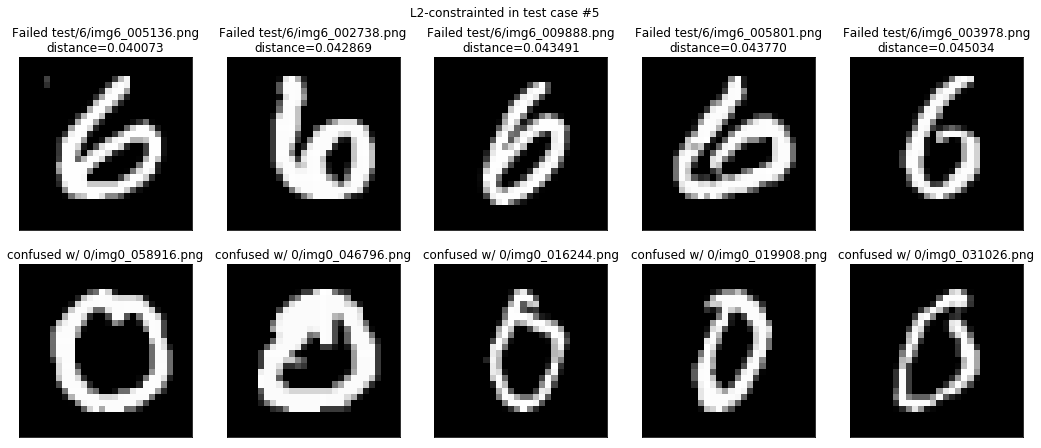

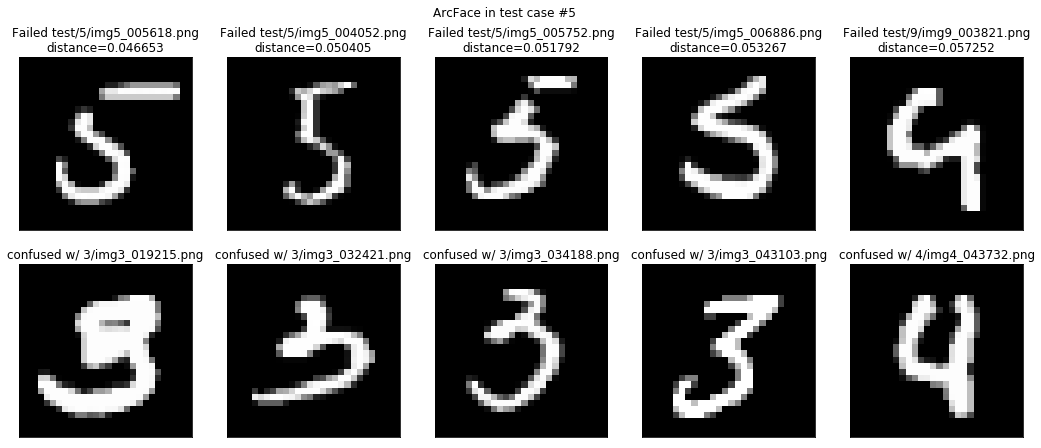

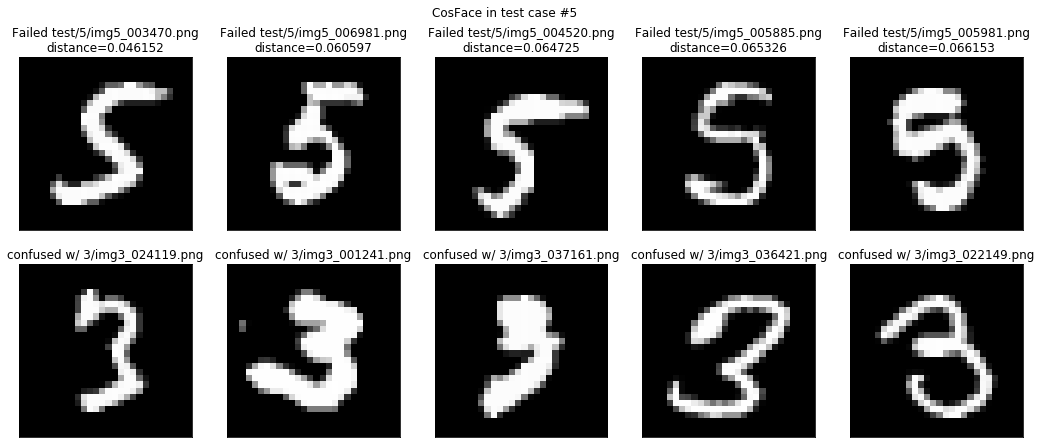

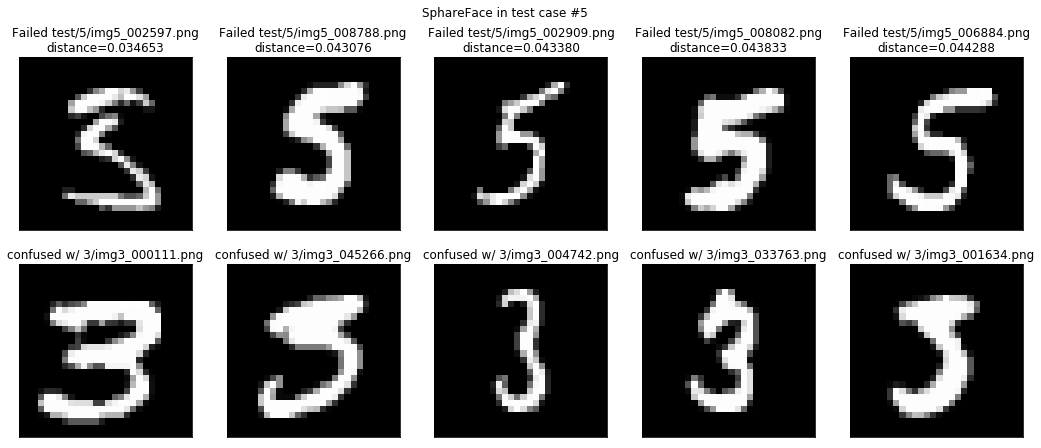

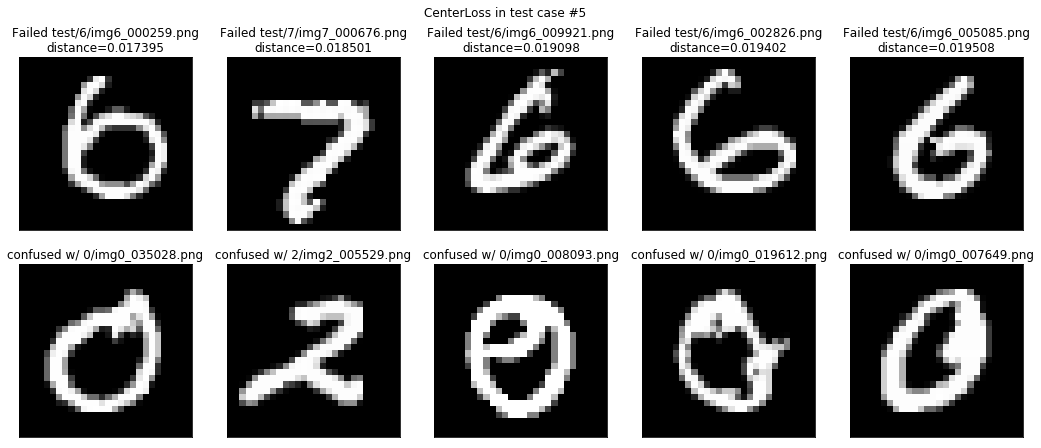

In [20]:
for i in [0, 5]: toytest.show_all_worst_test_images(i)